In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Greenland = pd.read_excel(filepath, sheet_name='Greenland-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Greenland)
fp.date_time(Greenland)

,Extent,Date
0,1076123.146,1979-01-01
1,1099248.063,1979-02-01
2,1036964.901,1979-03-01
3,958927.937,1979-04-01
4,823812.694,1979-05-01
...,...,...
533,721350.515,2023-06-01
534,459033.164,2023-07-01
535,282045.909,2023-08-01
536,270397.608,2023-09-01


In [5]:
scaler = MinMaxScaler()
Greenland['Extent'] = scaler.fit_transform(Greenland['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 5
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Greenland['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((522, 12, 1), (522,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Greenland_model_LT5/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 24s 297ms/step - loss: 0.3072 - root_mean_squared_error: 0.5543 - val_loss: 0.1440 - val_root_mean_squared_error: 0.3794
Epoch 2/50
53/53 [==============================] - 14s 274ms/step - loss: 0.1773 - root_mean_squared_error: 0.4210 - val_loss: 0.0255 - val_root_mean_squared_error: 0.1598
Epoch 3/50
53/53 [==============================] - 13s 249ms/step - loss: 0.0332 - root_mean_squared_error: 0.1823 - val_loss: 0.0242 - val_root_mean_squared_error: 0.1554
Epoch 4/50
53/53 [==============================] - 15s 282ms/step - loss: 0.0301 - root_mean_squared_error: 0.1736 - val_loss: 0.0236 - val_root_mean_squared_error: 0.1537
Epoch 5/50
53/53 [==============================] - 14s 269ms/step - loss: 0.0295 - root_mean_squared_error: 0.1717 - val_loss: 0.0234 - val_root_mean_squared_error: 0.1529
Epoch 6/50
53/53 [==============================] - 2s 36ms/step - loss: 0.0286 - root_mean_squared_error: 0.1690 - val_loss: 0.0235 - 

53/53 [==============================] - 18s 340ms/step - loss: 0.0145 - root_mean_squared_error: 0.1203 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1179
Epoch 28/50
53/53 [==============================] - 2s 38ms/step - loss: 0.0146 - root_mean_squared_error: 0.1210 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1181
Epoch 29/50
53/53 [==============================] - 14s 271ms/step - loss: 0.0150 - root_mean_squared_error: 0.1226 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1171
Epoch 30/50
53/53 [==============================] - 16s 302ms/step - loss: 0.0134 - root_mean_squared_error: 0.1159 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1163
Epoch 31/50
53/53 [==============================] - 17s 316ms/step - loss: 0.0128 - root_mean_squared_error: 0.1132 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1158
Epoch 32/50
53/53 [==============================] - 2s 44ms/step - loss: 0.0139 - root_mean_squared_error: 0.1177 - val_loss: 0.0135 - val_root

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

9.82513701915741 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

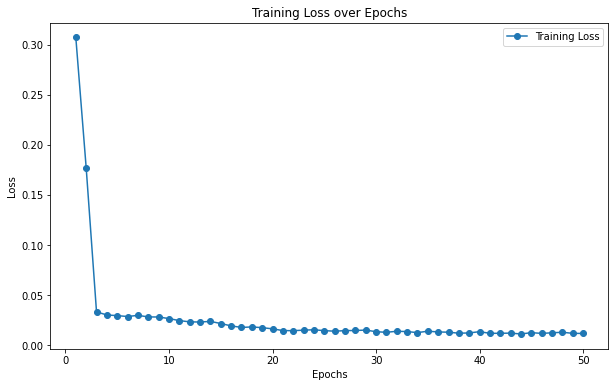

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

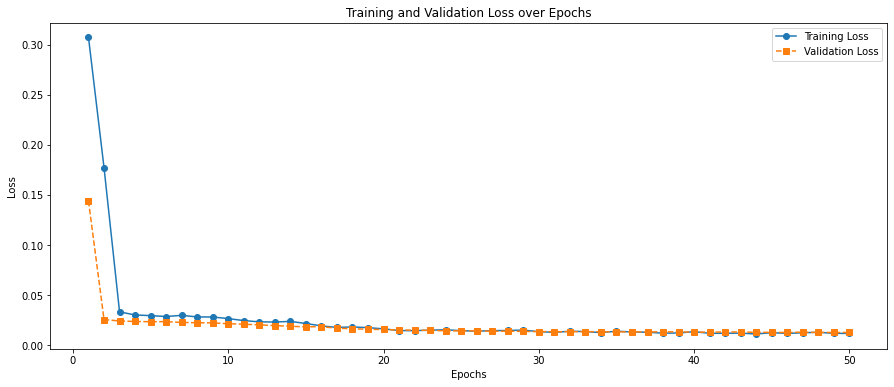

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Greenland_model_LT5/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 2s 23ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.10472292587745473
MAE : 0.08420134206373531


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,304563.00000,212475.431
1,367302.03125,386546.857
2,453889.06250,547183.986
3,534868.43750,584596.262
4,591849.62500,584830.109
5,620057.56250,641562.292
6,624511.43750,734946.437
7,611520.81250,777596.225
8,574956.37500,687087.673
9,515747.53125,622337.816


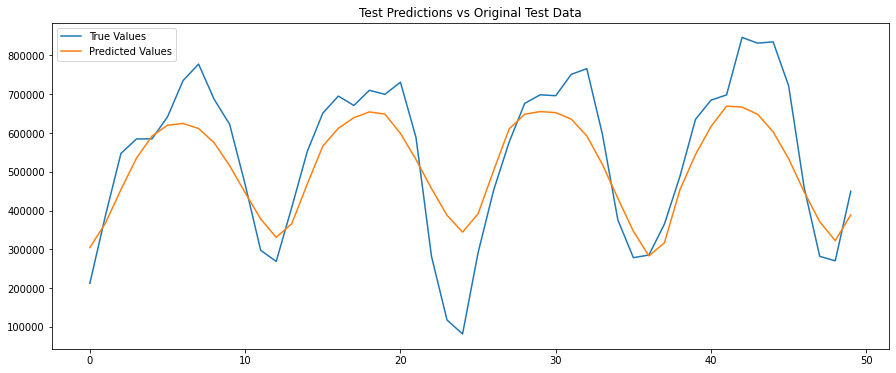

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 25ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

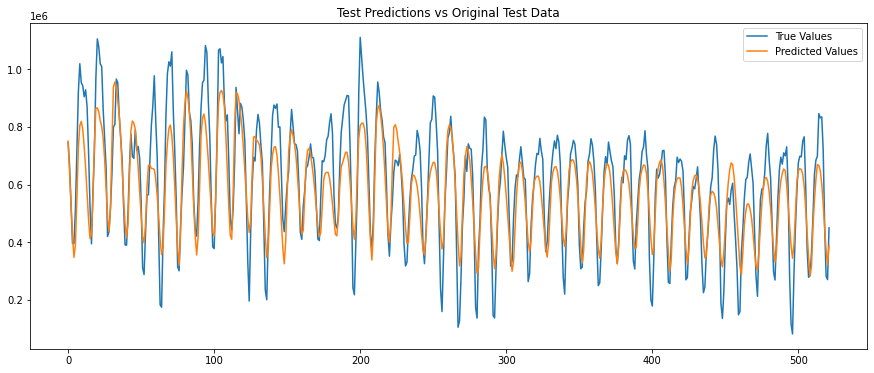

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()